# Surface Temperature Quantile Notebook
This notebook looks at how the high quantiles for surface temperature vary with longwave optical depth ($CO_2$ concentration proxy) on an aquaplanet.

In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-01-12 09:48:34,719 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

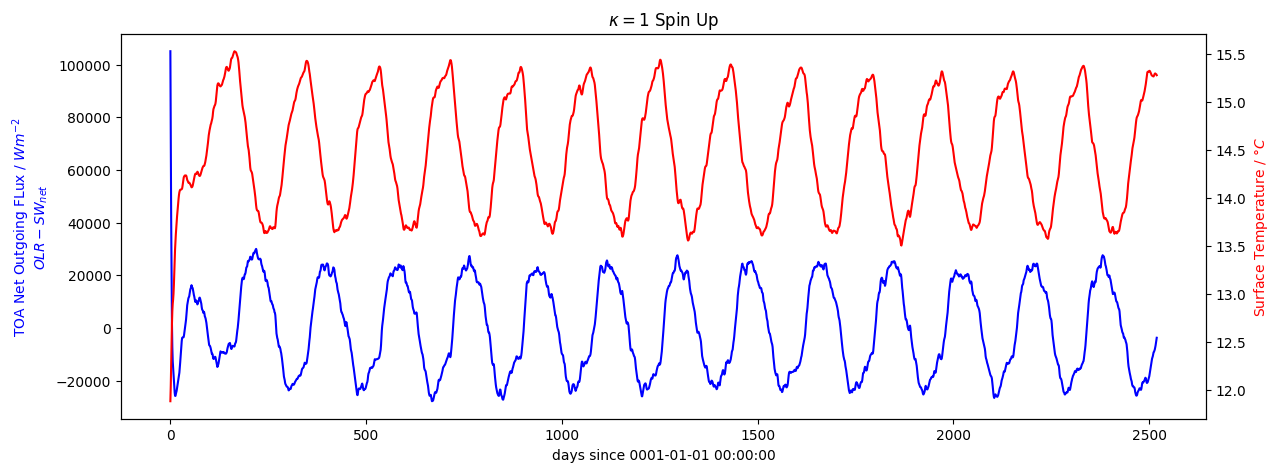

In [4]:
# Plot spin up time
spin_up_ind = np.where(np.asarray(tau_lw)==1)[0][0]     # Use dataset with earthlike optical depth for spin up plot
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds[spin_up_ind].olr, frierson_net_toa_sw_dwn(ds[spin_up_ind].swdn_toa, ds[spin_up_ind].ps,
                                                                          albedo[spin_up_ind], tau_sw[spin_up_ind]),
                             ds[spin_up_ind].t_surf, ax)
plt.title('$\kappa = 1$ Spin Up');

## Surface Temperature Quantile
Plot quantile of surface temperature vs global average surface temperature for a given latitude band.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [5]:
# Compute Global Average Surface Temperature
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
temp_av = np.zeros(n_exp)
for i in range(n_exp):
    temp_av[i] = area_weighting(ds[i].sel(time=slice(use_time_start, np.inf)).t_surf).mean(dim=['lon', 'lat', 'time']).to_numpy()


In [6]:
# Compute quantile surface temperature across longitude and time dimension for each latitude
quantiles = [90, 99, 99.9, 99.99]
n_quantiles = len(quantiles)
latitudes = ds[0].lat.to_numpy()
n_latitude = len(latitudes)
weights = np.cos(np.deg2rad(latitudes))
temp_quant = np.zeros((n_exp, n_quantiles, n_latitude))
for i in range(n_exp):
    # Collapse longitude and time dimensions because they are all equivalent in an aquaplanet (expect for the seasonality).
    data_use = ds[i].sel(time=slice(use_time_start, np.inf)).t_surf.stack(lon_time=("lon","time"),
                                                                          create_index=False).chunk(dict(lon_time=-1))
    for j in range(n_quantiles):
        temp_quant[i, j, :] = data_use.quantile(quantiles[j]/100, dim='lon_time').to_numpy()


In [31]:
# Only consider a given latitude range
region = 'Tropics'      # Tropics or Extratropics
if region.lower() == 'tropics':
    lat_min = 0
    lat_max = 20
elif region.lower() == 'extratropics':
    lat_min = 30
    lat_max = 60
else:
    raise ValueError('Not valid region')
lat_use = np.where(np.logical_and(np.abs(latitudes)<lat_max, np.abs(latitudes)>=lat_min))[0]

# Don't think it is appropriate to use weights because the percentiles at different locations correspond to different days
# Weighting makes sense for global average temperature but not for this I don't think
temp_quant_use = np.average(temp_quant[:, :, lat_use], axis=2)
# temp_quant_use = np.average(temp_quant[:, :, lat_use], axis=2, weights = weights[lat_use])

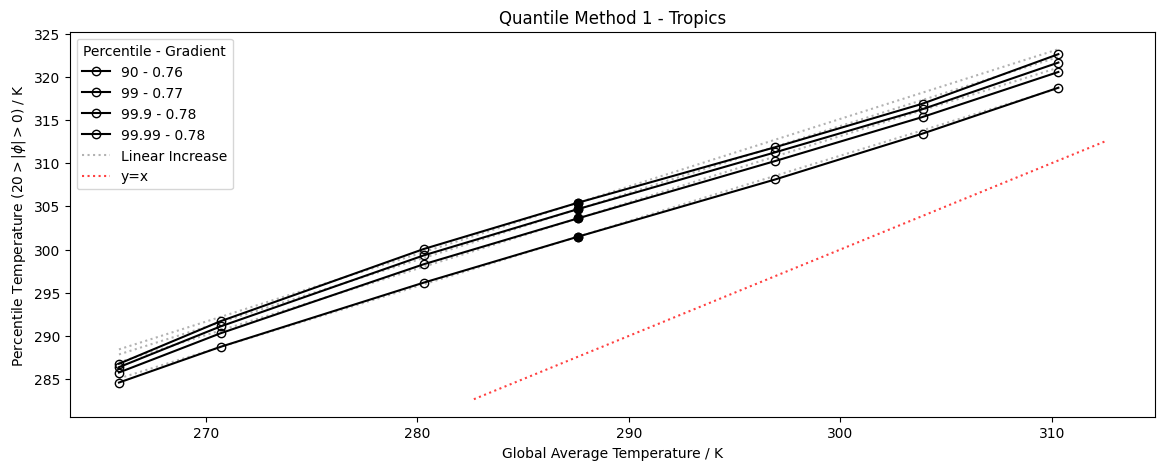

In [32]:
tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
fig, ax = plt.subplots(1,1, figsize=(14, 5))
for j in range(n_quantiles):
    fit_func = lambda x, m: temp_quant_use[tau_ref_ind, j] + m*(x-temp_av[tau_ref_ind])         # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant_use[:, j])[0]
    ax.plot(temp_av, temp_quant_use[:, j], marker='o', label='{} - {:.2f}'.format(quantiles[j], param[0]),
            color='k', fillstyle='none')
    # Filled circle for reference simulation
    ax.plot(temp_av[tau_ref_ind], temp_quant_use[tau_ref_ind, j], marker='o', color='k', fillstyle='full')
    if j==n_quantiles-1:
        label = 'Linear Increase'
    else:
        label = None
    ax.plot(temp_av, fit_func(temp_av, param), linestyle=':', color='k', alpha=0.3, label=label)

# # now plot y=x so can see how the rate compares to the increase of the mean
ax.plot([ax.get_ylim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax.legend(title='Percentile - Gradient')
ax.set_xlabel('Global Average Temperature / K')
ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
ax.set_title(f'Quantile Method 1 - {region}');

The linear increase above and below is just a straight line fit that goes through the reference point, for which the optical depth parameter is 1.

The plot below shows the quantiles computed across all latitudes, longitudes and time in the given latitude range. There doesn't really seem to be much difference between the two methods of computing the quantiles.

In [29]:
# Compute quantile across all selected latitudes rather than for each latitude.
temp_quant_use2 = np.zeros((n_exp, n_quantiles))
temp_local_mean = np.zeros(n_exp)     # record mean temperature in the given latitude range
temp_local_summer_mean = np.zeros(n_exp)    # record mean summer temperature in given latitude range
for i in range(n_exp):
    # Collapse longitude and time dimensions because they are all equivalent in an aquaplanet (expect for the seasonality).
    data_use = ds[i].where((np.abs(ds[i].lat) <= lat_max) & (np.abs(ds[i].lat) >= lat_min),
                           drop=True).sel(time=slice(use_time_start, np.inf))
    ds_nh_summer = isca_tools.utils.annual_time_slice(data_use, [6, 7, 8]).sel(lat=slice(0, lat_max))    # NH summer is JJA
    ds_sh_summer = isca_tools.utils.annual_time_slice(data_use, [12, 1, 2]).sel(lat=slice(-lat_max, 0))    # SH summer is DJF
    temp_summer = xr.concat([ds_nh_summer.t_surf.mean(dim=('lon', 'time')), ds_sh_summer.t_surf.mean(dim=('lon', 'time'))], dim='lat')
    temp_local_summer_mean[i] = temp_summer.mean().to_numpy()
    temp_local_mean[i] = data_use.t_surf.mean(dim=['lon', 'time', 'lat'])
    # Forget weighted mean for now - not sure if appropriate for this analysis - THIS MAY BE WRONG THOUGH!!!
    # temp_local_summer_mean[i] = area_weighting(temp_summer).mean().to_numpy()
    # temp_local_mean[i] = area_weighting(data_use.t_surf).mean(dim=['lon', 'time', 'lat'])
    data_use = data_use.t_surf.stack(lon_lat_time=("lon","time", "lat"), create_index=False).chunk(dict(lon_lat_time=-1)).to_numpy()
    temp_quant_use2[i, :] = np.quantile(data_use, np.asarray(quantiles)/100)

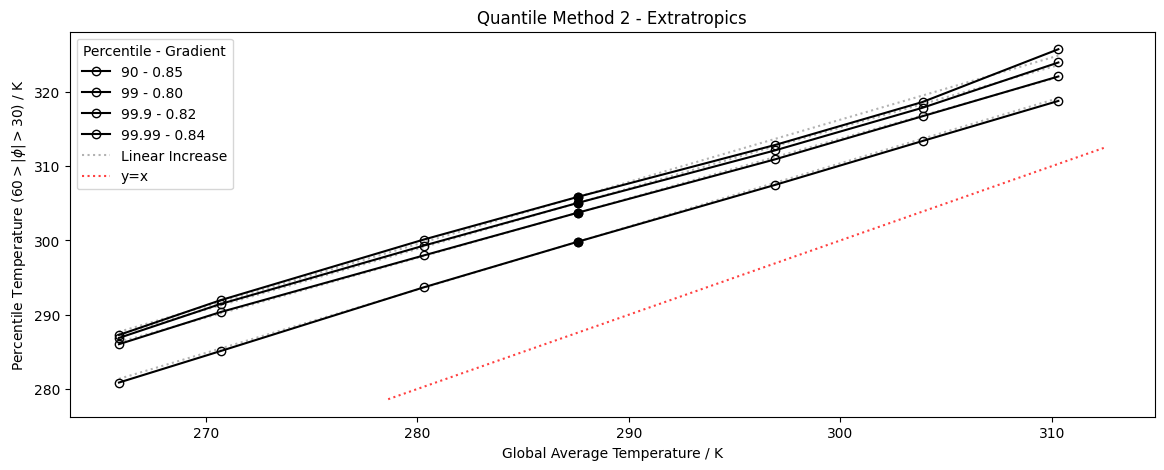

In [30]:
fig, ax = plt.subplots(1,1, figsize=(14, 5))
for j in range(n_quantiles):
    fit_func = lambda x, m: temp_quant_use2[tau_ref_ind, j] + m*(x-temp_av[tau_ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant_use2[:, j])[0]
    ax.plot(temp_av, temp_quant_use2[:, j], marker='o', label='{} - {:.2f}'.format(quantiles[j], param[0]),
        color='k', fillstyle='none')
    # Filled circle for reference simulation
    ax.plot(temp_av[tau_ref_ind], temp_quant_use2[tau_ref_ind, j], marker='o', color='k', fillstyle='full')
    if j==n_quantiles-1:
        label = 'Linear Increase'
    else:
        label = None
    ax.plot(temp_av, fit_func(temp_av, param), linestyle=':', color='k', alpha=0.3, label=label)
ax.plot([ax.get_ylim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax.legend(title='Percentile - Gradient')
ax.set_xlabel('Global Average Temperature / K')
ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
ax.set_title(f'Quantile Method 2 - {region}');

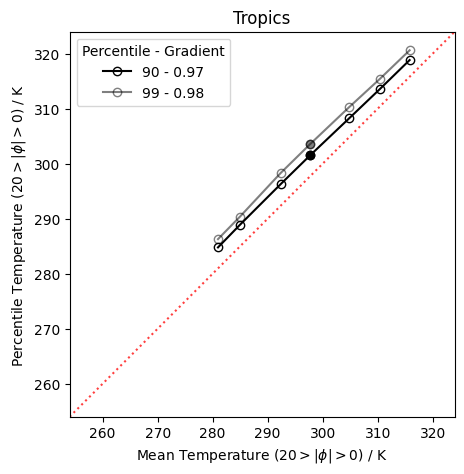

In [11]:
# Plot local quantile temperature vs local mean temperature within the given latitude band
fig, ax = plt.subplots(1,1, figsize=(14, 5))
x_var_use = 'mean'   # Can choose summer mean temperature or overall mean temperature to plot
if x_var_use == 'summer_mean':
    x_var = temp_local_summer_mean
    ax.set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
else:
    x_var = temp_local_mean
    ax.set_xlabel(f'Mean Temperature (${lat_max}>|\phi| > {lat_min}$) / K')

quantile_method = 2     # Can choose whether to use method 1 or 2 for computing the quantile temperature
if quantile_method == 2:
    y_var = temp_quant_use2
else:
    y_var = temp_quant_use

for j in range(2):
    fit_func = lambda x, m: y_var[tau_ref_ind, j] + m*(x-x_var[tau_ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,x_var, y_var[:, j])[0]
    ax.plot(x_var, y_var[:, j], marker='o', label='{} - {:.2f}'.format(quantiles[j], param[0]),
            color='k', fillstyle='none', alpha=1-0.5*j)
    # Filled circle for reference simulation
    ax.plot(x_var[tau_ref_ind], y_var[tau_ref_ind, j], marker='o', color='k', fillstyle='full', alpha=1-0.5*j)
lims = [254, 324]
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# now plot both limits against eachother
ax.plot(lims, lims, 'r:', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
ax.legend(title='Percentile - Gradient')
ax.set_title(region);
# plt.savefig('/Users/joshduffield/Desktop/hello2.png', bbox_inches='tight', dpi=400)

## Attempt to replicate Figure 2 of Byrne 2021
I.e. want to plot change between $\kappa = 2$ and $\kappa = 1$ simulations for each quantile of temperature. Then compare this to the change in the mean temperature, through the scaling factor.


In [12]:
# Get change for each quantile between a warmed world and a reference world
ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
tau_lw_warm = 2
warm_ind = np.where(np.asarray(tau_lw)==tau_lw_warm)[0][0]
quantiles_all = np.arange(100)
temp_all_quant = np.zeros((2, len(quantiles_all)))
for i in range(2):
    if i == 0:
        data_use = ds[ref_ind]
    else:
        data_use = ds[warm_ind]
    data_use = data_use.where((np.abs(data_use.lat) <= lat_max) & (np.abs(data_use.lat) >= lat_min),
                              drop=True).sel(time=slice(use_time_start, np.inf))
    data_use = data_use.t_surf.stack(lon_lat_time=("lon","time", "lat"), create_index=False).chunk(dict(lon_lat_time=-1)).to_numpy()
    quant_thresh = np.quantile(data_use, quantiles_all/100)
    for j in tqdm(quantiles_all):
        # Average temperature over days exceeding the percentile
        temp_all_quant[i, j] = data_use[data_use>quant_thresh[j]].mean()

100%|██████████| 100/100 [00:00<00:00, 203.29it/s]


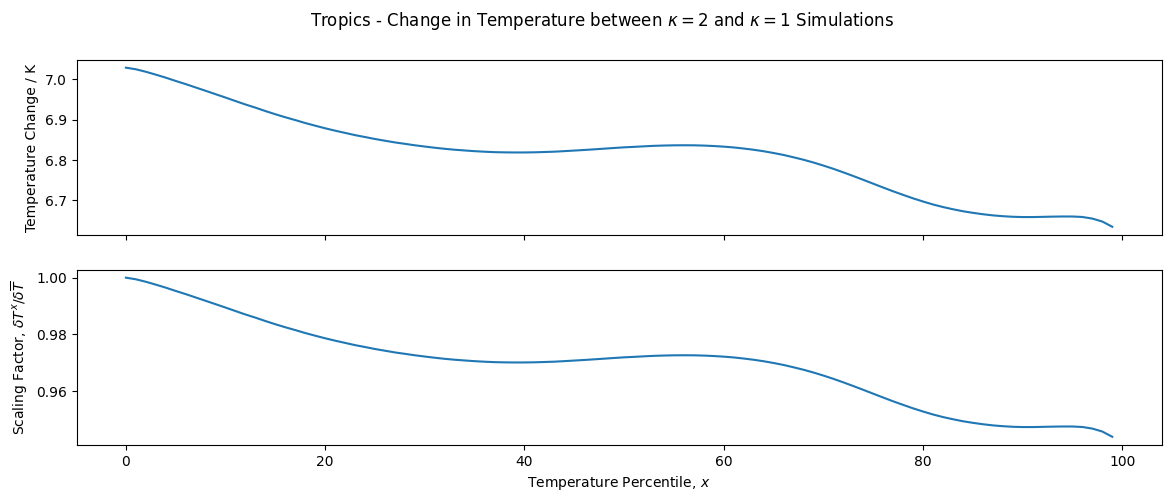

In [13]:
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_all_quant[1]-temp_all_quant[0])
ax[0].set_ylabel('Temperature Change / K')
ax[1].plot(quantiles_all, (temp_all_quant[1]-temp_all_quant[0])/(temp_local_mean[warm_ind] - temp_local_mean[ref_ind]))
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");


## Variation with latitude
The plot below is inspired by Figure 2 in *O'Gorman Schneider 2009*, showing the change in the 99.9 percentile and mean temperature with respect to a reference experiment, as a function of latitude.


In [14]:
# Get change in a given percentile of temperature between a warmer simulation and a reference
quant_plot = 99.9
temp_quant_ref = temp_quant[np.asarray(tau_lw)==tau_lw_ref, np.asarray(quantiles)==quant_plot, :].flatten()
temp_quant_warm = temp_quant[np.asarray(tau_lw)==tau_lw_warm, np.asarray(quantiles)==quant_plot, :].flatten()
temp_quant_diff = (temp_quant_warm-temp_quant_ref)
global_temp_diff = float(temp_av[np.asarray(tau_lw)==tau_lw_warm] - temp_av[np.asarray(tau_lw)==tau_lw_ref])

In [15]:
# Get change in mean temperature
mean_temp_ref = ds[np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]].sel(time=slice(use_time_start, np.inf)
                                                                       ).t_surf.mean(dim=["lon","time"])
mean_temp_warm = ds[np.where(np.asarray(tau_lw)==tau_lw_warm)[0][0]].sel(time=slice(use_time_start, np.inf)
                                                                         ).t_surf.mean(dim=["lon","time"])
mean_temp_diff = (mean_temp_warm-mean_temp_ref)

Results are normalised by Global Mean Surface Temperature Difference of 9.32 K


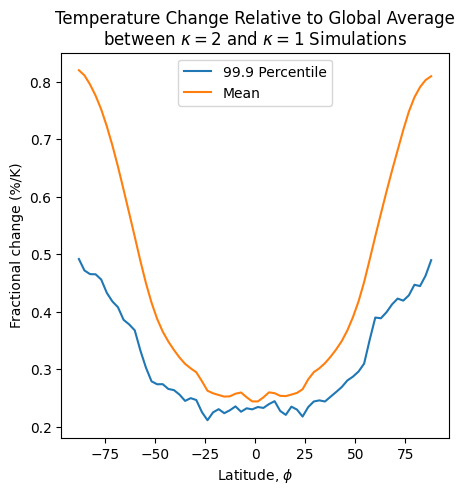

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(latitudes, temp_quant_diff / global_temp_diff / temp_quant_ref * 100, label=f"{quant_plot} Percentile")
ax.plot(latitudes, mean_temp_diff / global_temp_diff / mean_temp_ref * 100, label="Mean")
ax.set_ylabel('Fractional change (%/K)')
ax.set_xlabel('Latitude, $\phi$')
ax.legend()
ax.set_title(f'Temperature Change Relative to Global Average\nbetween $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations')
print("Results are normalised by Global Mean Surface Temperature Difference of {:.2f} K".format(global_temp_diff))